### Kernighan-Lin Heuristic
This code implements the Kernighan-Lin algorithm, described [here](https://ieeexplore.ieee.org/document/6771089), to partition a bipartite graph (weighted or unweighted edges) into a number of specified partitions, with the objective of minimizing the (weighted) sum of edges crossing partitions. 

Since this is simply a heuristic, it does not guarantee an optimal solution and how different parameters impact its performance (KL_modified, random_labels), and how it performs relative to other clustering algorithms, will likely depend on the graph at hand. However, some preliminary benchmarking suggests that the algorithm performs better (with respect to the objective function), when compared to other methods, such as spectral clustering. 

Other algorithms have other objectives; The Leiden clustering algorithm maximizes a "modularity" score [here](https://www.nature.com/articles/s41598-019-41695-z) as its objective function, which quantifies how connected nodes within a partition are compared to a random network. As such, which algorithm we want to use to remove redundancies in our biological pathway databases depends on our biological motivation... [Note: Let's look at how the Kernighan heuristic peforms with regard to modularity.]

<img src="README_files/method2.png" alt= “” width="80%" height="80%">

### Other Sources: 
[CMU](https://www.cs.cmu.edu/~ckingsf/bioinfo-lectures/kernlin.pdf)\
[Wikipedia](https://en.wikipedia.org/wiki/Kernighan%E2%80%93Lin_algorithm)


### Example run


1. load dependencies

In [4]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns

from geneclusters.cluster_genes_new import get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite

2. Download pathway database(s)

In [3]:
# run with internet
x = gseapy.get_library('HumanCyc_2016')
np.save('HumanCyc_2016.npy', x)

3. Iterate over multiple initiations

In [5]:
help(get_kernighan_lin_clusters)

Help on function get_kernighan_lin_clusters in module geneclusters.cluster_genes_new:

get_kernighan_lin_clusters(path, threshold, C, KL_modified=True, random_labels=True, unweighted=True, seed=5)
    returns pandas dataframe annotating each gene and pathway to a cluster, based on pathway-gene dictionary and args
    Args:
        path str
            path to pathway-gene dictionary as ndarray
        threshold int
            if random_labels is True, gives number of genes per cluster. Min = 1, Max = total number of genes and pathways
            if random_labels is False, gives number of desired clusters. Min = 1, Max = total number of genes and pathways
        C float
            probability of false negative pathway-gene association (0<=c<= 1)
        KL_modified bool
            whether to run the modified KL algorithm 
        random_labels
            whether to randomize initiating labels or assign based on node centrality
        unweighted bool
            whether to conside

In [6]:
path = './examples/HumanCyc_2016.npy'
repeats = 500

thresh = np.repeat(30,repeats)
seed = np.arange(repeats)
C = 0
KL_modified = True
random_labels = True
unweighted = True

results = process_map(partial(get_scores,path,C,KL_modified,random_labels,unweighted), seed, thresh)


  0%|          | 0/500 [00:00<?, ?it/s]

3it [00:06,  2.06s/it, tot_impr=1444, last_impr=0, loss=410] ] 
3it [00:06,  2.17s/it, tot_impr=1499, last_impr=0, loss=361]   
3it [00:06,  2.19s/it, tot_impr=1455, last_impr=0, loss=388] 
3it [00:06,  2.19s/it, tot_impr=1441, last_impr=0, loss=410] 
3it [00:06,  2.21s/it, tot_impr=1443, last_impr=0, loss=395] 
3it [00:06,  2.21s/it, tot_impr=1467, last_impr=0, loss=390]  
4it [00:06,  1.67s/it, tot_impr=1414, last_impr=0, loss=425]
4it [00:06,  1.67s/it, tot_impr=1435, last_impr=0, loss=423]
4it [00:06,  1.69s/it, tot_impr=1454, last_impr=0, loss=393]
4it [00:06,  1.67s/it, tot_impr=1432, last_impr=0, loss=430] 
3it [00:06,  2.26s/it, tot_impr=1442, last_impr=0, loss=414] 
4it [00:06,  1.69s/it, tot_impr=1409, last_impr=0, loss=444] 
4it [00:06,  1.67s/it, tot_impr=1415, last_impr=0, loss=437] 0]
3it [00:06,  2.29s/it, tot_impr=1460, last_impr=0, loss=381] 
4it [00:07,  1.77s/it, tot_impr=1399, last_impr=0, loss=456]
4it [00:06,  1.74s/it, tot_impr=1446, last_impr=0, loss=404] 
4it [

4. Select labels from the best loss

In [7]:
loss = np.hstack([x[1] for x in results])
labs = np.vstack([x[0] for x in results])
labels = labs[np.argmin(loss)]

In [8]:
# assign the clusters
frame, loss_temp = get_kernighan_lin_clusters(path, 30, C, KL_modified, random_labels, unweighted, seed=seed[np.argmin(loss)])
frame.columns = ['cluster', 'description', 'is_gene']


6it [00:06,  1.15s/it, tot_impr=1509, last_impr=0, loss=349]   


In [9]:
frame[frame['cluster']==23]['description']

11                                                 ACAD8
13                                                ACADSB
90                                               ALDH6A1
135                                                  AUH
147                                                BCAT1
148                                                BCAT2
149                                               BCKDHA
150                                               BCKDHB
243                                                  DBT
261                                                  DLD
277                                                ECHS1
426                                                HADHA
434                                               HIBADH
435                                                HIBCH
442                                              HMGCLL1
461                                             HSD17B10
509                                                  IVD
543                            

5. Order matrix entries by labeling

In [10]:
mat = get_gene_pathway_matrix('./examples/HumanCyc_2016.npy')
matrix = np.ascontiguousarray(mat.values.T)

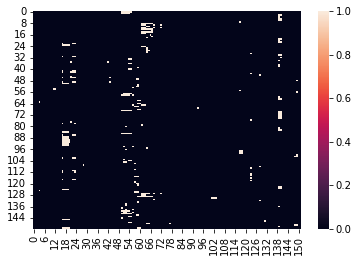

In [11]:
sns.heatmap(matrix[np.argsort(frame[frame['is_gene']]['cluster'])][np.argsort(frame[np.invert(frame['is_gene'])]['cluster'])])
plt.show()

6. Order matrix entries randomly

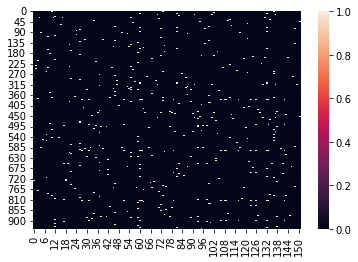

In [12]:
sns.heatmap(matrix[np.random.permutation(range(matrix.shape[0]))][:,np.random.permutation(range(matrix.shape[1]))])
plt.show()